In [62]:
import pandas as pd
import numpy as np

def fmt_df(feature_df):

    fakefollower_accounts = feature_df[feature_df[feature_df.columns[1]].values == 'bot-fakefollower']
    socialspam_accounts = feature_df[feature_df[feature_df.columns[1]].values == 'bot-socialspam']
    traditionspam_accounts = feature_df[feature_df[feature_df.columns[1]].values == 'bot-traditionspam']
    human_accounts = feature_df[feature_df[feature_df.columns[1]].values == 'human']

    print('fakefollower_accounts.shape:', fakefollower_accounts.shape)
    print('socialspam_accounts.shape:', socialspam_accounts.shape)
    print('traditionspam_accounts.shape:', traditionspam_accounts.shape)
    print('human_accounts.shape:', human_accounts.shape)
    print()

    min_class_count = min(fakefollower_accounts.shape[0], socialspam_accounts.shape[0], traditionspam_accounts.shape[0], human_accounts.shape[0])
    fakefollower_accounts = fakefollower_accounts.head(min_class_count)
    socialspam_accounts = socialspam_accounts.head(min_class_count)
    traditionspam_accounts = traditionspam_accounts.head(min_class_count)
    human_accounts = human_accounts.head(min_class_count)
    
    feature_df = pd.concat([fakefollower_accounts, socialspam_accounts, traditionspam_accounts, human_accounts], ignore_index=True)
    feature_df = feature_df.sample(frac=1)

    return feature_df

In [63]:
import pandas as pd
import numpy as np


print("Start to load the features")
feature_df = pd.read_csv('results/features_merged-v1.csv')

print(f"Shuffle the features of {len(feature_df)} samples")
feature_df = feature_df.sample(frac=1)
feature_df = fmt_df(feature_df)

Start to load the features
Shuffle the features of 10065 samples
fakefollower_accounts.shape: (805, 175)
socialspam_accounts.shape: (4218, 175)
traditionspam_accounts.shape: (2272, 175)
human_accounts.shape: (2770, 175)



In [64]:
X_df = feature_df.drop(columns = ['class','user_id'])
X1 = np.array(X_df)
X_df.shape

(3220, 173)

In [65]:
y = feature_df['class'].values
y_names = np.unique(feature_df['class'].values)
y_names

array(['bot-fakefollower', 'bot-socialspam', 'bot-traditionspam', 'human'],
      dtype=object)

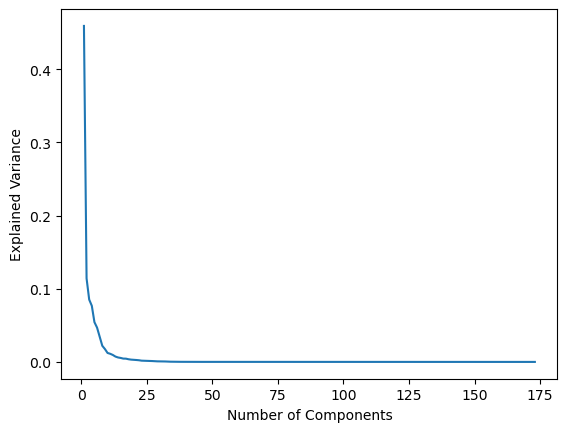

In [66]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA()

pca.fit(X1)  # X is your data
explained_variance = pca.explained_variance_ratio_

plt.plot(range(1, len(explained_variance) + 1), explained_variance)
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')
plt.show()

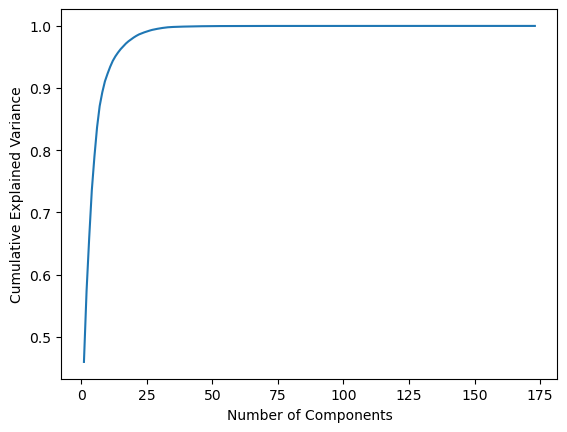

In [67]:
cumulative_variance = np.cumsum(explained_variance)

plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()


In [68]:
pca=PCA(n_components=25)
x_new = pca.fit_transform(X1)

In [69]:
y[5]

'human'

In [70]:
from sklearn.model_selection import train_test_split as tts
Xtrain,Xtest,ytrain,ytest = tts(x_new, y, test_size=0.3, random_state=201)

In [71]:
np.unique(ytest)

array(['bot-fakefollower', 'bot-socialspam', 'bot-traditionspam', 'human'],
      dtype=object)

In [86]:
from sklearn.ensemble import RandomForestClassifier as RFC
rfc = RFC(random_state = 201, n_estimators = 100, max_depth = 30, min_samples_split=4)

In [87]:
rfc.fit(Xtrain, ytrain)
y_pred = rfc.predict(Xtest)

In [88]:
def compare_classes(actual, predicted, names=None):
    '''Function returns a confusion matrix, and overall accuracy given:
            Input:  actual - a list of actual classifications
                    predicted - a list of predicted classifications
                    names (optional) - a list of class names
    '''
    accuracy = sum(actual==predicted)/actual.shape[0]
    
    classes = pd.DataFrame(columns = ['Actual', 'Predicted'])
    classes['Actual'] = actual
    classes['Predicted'] = predicted

    conf_mat = pd.crosstab(classes['Actual'], classes['Predicted'])
    
    if type(names) != type(None):            
        conf_mat.index = names
        conf_mat.index.name = 'Actual'
        conf_mat.columns = names
        conf_mat.columns.name = 'Predicted'
    
    print('Accuracy = ' + format(accuracy, '.2f'))
    return conf_mat, accuracy

In [89]:
compare_classes(ytest, y_pred, y_names)

Accuracy = 0.88


(Predicted          bot-fakefollower  bot-socialspam  bot-traditionspam  human
 Actual                                                                       
 bot-fakefollower                196               0                 22     30
 bot-socialspam                    2             232                  0      1
 bot-traditionspam                36               1                186      5
 human                             7               4                  4    240,
 0.8840579710144928)

In [90]:
def do_Kfold(model,X,y,k,scaler = None, random_state = 146):
    from sklearn.model_selection import KFold
    
    kf = KFold(n_splits=k, random_state = random_state, shuffle=True)

    train_scores = []
    test_scores = []

    for idxTrain, idxTest in kf.split(X):
        Xtrain = X[idxTrain, :]
        Xtest = X[idxTest, :]
        ytrain = y[idxTrain]
        ytest = y[idxTest]
        if scaler != None:
            Xtrain = scaler.fit_transform(Xtrain)
            Xtest = scaler.transform(Xtest)

        model.fit(Xtrain,ytrain)

        train_scores.append(model.score(Xtrain,ytrain))
        test_scores.append(model.score(Xtest,ytest))
        
    return train_scores, test_scores

In [91]:
X = np.array(X_df)

In [92]:
from sklearn.model_selection import KFold, GridSearchCV

param_grid = dict(n_estimators=[1,100,500],max_depth = [30,60,90],
                 min_samples_split = [2,3,4,5,10]) #params to test
cv = KFold(n_splits=10, random_state=146, shuffle = True)
#add verbose = 2
grid = GridSearchCV(RFC(random_state = 146), param_grid=param_grid, cv=cv, 
                    scoring='accuracy')

In [93]:
grid.fit(Xtrain, ytrain)

GridSearchCV(cv=KFold(n_splits=10, random_state=146, shuffle=True),
             estimator=RandomForestClassifier(random_state=146),
             param_grid={'max_depth': [30, 60, 90],
                         'min_samples_split': [2, 3, 4, 5, 10],
                         'n_estimators': [1, 100, 500]},
             scoring='accuracy')

In [94]:
print(
    f'The best parameters are {grid.best_params_} with a score of {grid.best_score_:.2f}'
)

The best parameters are {'max_depth': 30, 'min_samples_split': 4, 'n_estimators': 100} with a score of 0.88


In [82]:
results = pd.DataFrame(grid.cv_results_)[['param_n_estimators','param_max_depth',
                                'param_min_samples_split','mean_test_score','rank_test_score']]

In [83]:
results.head()

,param_n_estimators,param_max_depth,param_min_samples_split,mean_test_score,rank_test_score
0,1,5,2,0.742201,58
1,100,5,2,0.843813,38
2,500,5,2,0.844260,36
3,1,5,3,0.742201,58
4,100,5,3,0.842486,40


In [84]:
results[results['rank_test_score'] == 1]

,param_n_estimators,param_max_depth,param_min_samples_split,mean_test_score,rank_test_score
52,100,30,4,0.879316,1


In [85]:

plt.plot(depth_range, train, '-xk', label='Training')
plt.plot(depth_range, test, '-xr', label='Testing')
plt.xlabel('Max Depth')
plt.ylabel('Classification Accuracy')
plt.legend()
plt.show()

NameError: name 'depth_range' is not defined

In [ ]:
depth_range[np.argmax(test)]